In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [43]:
# Load the dataset
df = pd.read_csv('./final-weather-flight-data/processed_dataset_YUL-Flights-Weather.csv')

In [44]:
# Separate features and target variable
X = df.drop('Departure Delay (min)', axis=1)
y = df['Departure Delay (min)']

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': xgb.XGBRegressor(random_state=42),
    'SVR': SVR(),
    'Ensemble': VotingRegressor(
        estimators=[
            ('lr', LinearRegression()),
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', xgb.XGBRegressor(random_state=42)),
            ('svm', SVR())
        ]
    )
}

In [47]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [48]:
# Test and validate different models
results = {}
for name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

LinearRegression - MSE: 0.93, R2: 0.01
RandomForestRegressor - MSE: 1.03, R2: -0.10
GradientBoostingRegressor - MSE: 0.91, R2: 0.04
XGBRegressor - MSE: 1.02, R2: -0.08
SVR - MSE: 0.96, R2: -0.02
Ensemble - MSE: 0.91, R2: 0.03


In [49]:
# Define the parameter grid for each model
param_grids = {
    'LinearRegression': {},
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }
}

# Function to perform grid search and update the model with best parameters
def grid_search_tuning(model, params, X_train, y_train):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Perform grid search for each model
best_models = {}
for name in models:
    if param_grids[name]:  # Only perform grid search if there are parameters to tune
        print(f"Grid searching for {name}")
        best_models[name] = grid_search_tuning(models[name], param_grids[name], X_train, y_train)
    else:
        best_models[name] = models[name]  # For models without parameters, use the default

# Create a super ensemble model with the best models
super_ensemble = VotingRegressor(
    estimators=[(name, model) for name, model in best_models.items()]
)

# Evaluate the super ensemble model
mse, r2 = evaluate_model(super_ensemble, X_train, y_train, X_test, y_test)
print(f"Super Ensemble - MSE: {mse:.2f}, R2: {r2:.2f}")

# Update the models dictionary with the best models
models.update(best_models)

Grid searching for RandomForestRegressor
Grid searching for GradientBoostingRegressor
Grid searching for XGBRegressor
Grid searching for SVR


In [ ]:
# Function to perform optuna optimization and update the model with best parameters
def optuna_optimization(model, params, X_train, y_train, n_trials=10):
    def objective(trial):
        # Generate the hyperparameters using the trial object
        hyperparams = {param: trial.suggest_categorical(param, values) for param, values in params.items()}
        estimator = model(**hyperparams)
        score = cross_val_score(estimator, X_train, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
        return score.mean()  # Optuna tries to maximize the objective, hence return the mean of the negative MSE

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return model(**study.best_params)

# Perform optuna optimization for each model
optuna_best_models = {}
for name in models:
    if param_grids[name]:  # Only perform optimization if there are parameters to tune
        print(f"Optuna optimization for {name}")
        optuna_best_models[name] = optuna_optimization(models[name], param_grids[name], X_train, y_train)
    else:
        optuna_best_models[name] = models[name]  # For models without parameters, use the default

# Create a super ensemble model with the optuna optimized models
optuna_super_ensemble = VotingRegressor(
    estimators=[(name, model) for name, model in optuna_best_models.items()]
)

# Evaluate the optuna super ensemble model
optuna_mse, optuna_r2 = evaluate_model(optuna_super_ensemble, X_train, y_train, X_test, y_test)
print(f"Optuna Super Ensemble - MSE: {optuna_mse:.2f}, R2: {optuna_r2:.2f}")

# Update the models dictionary with the optuna optimized models
models.update(optuna_best_models)

In [ ]:
# Visualization pipeline
def plot_feature_importances(model, features):
    n_features = len(features)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

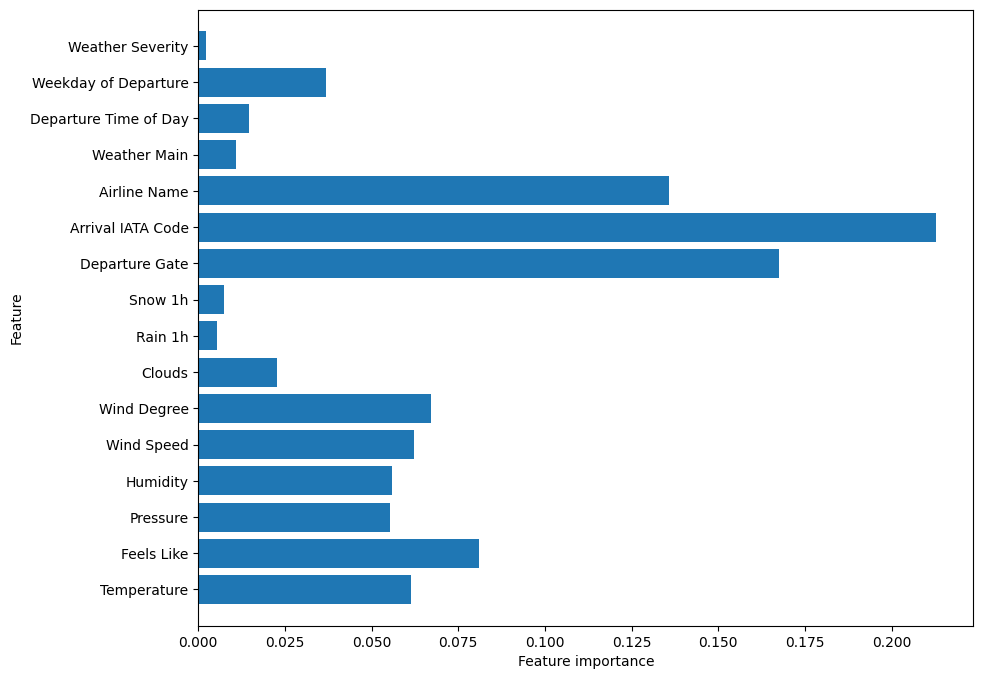

In [ ]:
# Plot feature importances for super_ensemble
if 'RandomForestRegressor' in models:
    rf_model = models['RandomForestRegressor']
    rf_model.fit(X_train, y_train)
    plt.figure(figsize=(10, 8))
    plot_feature_importances(rf_model, X.columns)
    plt.show()